# Modeling and Forecasting ETH Realized Variance using <br> Short-Memory (GARCH) and Long-Memory (HAR) Models

In [ ]:
# Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.graphics.gofplots import qqplot 
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model 

In [2]:
# Load minutely ETH 2023 data
df = pd.read_csv("./eth_df.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,OPEN,LOG_RETURN
date,,
2023-01-01 00:01:00,1196.02,-0.000067
2023-01-01 00:02:00,1196.02,0.000000
2023-01-01 00:03:00,1195.74,-0.000234
2023-01-01 00:04:00,1195.79,0.000042
2023-01-01 00:05:00,1196.29,0.000418


# Realized Variance Class

In [3]:
class RvModels:

    def __init__(self, name, returns):
        '''Store model names and returns series'''
        self.name = name   
        self.returns = returns  
        self.res = None  

    def fit(self, p: int = 1, o: int = 0, q: int = 1, vol: str = 'Garch', 
            dist: str = 'normal', mean: str = 'Constant', lags=None):
        '''Fit model with specified parameters'''
        self.res = arch_model(self.returns, mean=mean, lags=lags, vol=vol, 
                              p=p, o=o, q=q, dist=dist).fit(disp='off')
        return self.res

    @property
    def std_resid(self):
        '''Store standardized residuals'''
        return self.res.std_resid

    @property
    def cond_vol(self):
        '''Store conditional volatility'''
        return self.res.conditional_volatility

    def plot_diagnostics(self, lags=20):
        '''Plot diagnostics of standardized residuals'''

        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        ax1, ax2, ax3, ax4 = axes.flatten()

        # 1) Standardized Residuals Over Time
        ax1.plot(self.std_resid)
        ax1.set(
            title="Standardized Residuals Over Time",
            xlabel="Time",
            ylabel="Std. Residuals"
        )

        # 2) QQ‑Plot of Standardized Residuals (best‐fit line)
        qqplot(self.std_resid, line='45', ax=ax2, marker='o', markersize=3)
        ax2.set_title("QQ‑Plot of Standardized Residuals")

        # 3) ACF of Standardized Residuals
        plot_acf(self.std_resid, ax=ax3, lags=lags, alpha=0.05, missing='drop')
        ax3.set(title="ACF of Standardized Residuals")
        ax3.set_ylim(-0.50, 0.50)

        # 4) ACF of Squared Standardized Residuals
        plot_acf(self.std_resid**2, ax=ax4, lags=lags, alpha=0.05, missing='drop')
        ax4.set(title="ACF of Squared Standardized Residuals")
        ax4.set_ylim(-0.50, 0.50)

        fig.suptitle(f"{self.name} Diagnostics", fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def get_outliers(self, threshold: float = 3.0):
        '''Identify outliers based on standardized residuals'''

        if self.res is None:
            raise RuntimeError("Fit the model first.")

        sr = self.std_resid.dropna()
        mask = sr.abs() > threshold

        # Pull realized variance from your original rv_train by date
        rv_series = rv_train['REALIZED_VARIANCE']

        return pd.DataFrame({
            'STD_RESID': sr.loc[mask],
            'REALIZED_VARIANCE': rv_series.loc[mask]
        })

    def summary(self):
        '''Print model summary'''
        print(self.res.summary())

    def forecast_oos(self, test_index, horizon: int = 1) -> pd.Series:
        '''Generate out‐of‐sample variance forecasts'''

        if self.res is None:
            raise RuntimeError("Fit the model first.")

        f = self.res.forecast(horizon=horizon,
                              start=len(self.returns),
                              reindex=False)

        var_fc = f.variance.iloc[:, horizon-1].copy()
        var_fc.index = test_index

        return var_fc

    def level_metrics(self, results):
        '''Compute level metrics from log‐level results DataFrame'''

        actual_level = np.exp(results['ACTUAL_LOG_RV'])
        metrics = []
        for col in results.columns:
            if col.startswith('PRED_LOG_RV_'):
                name = col.replace('PRED_LOG_RV_', '')
                pred_l = np.exp(results[col])
                mse = ((pred_l - actual_level)**2).mean()
                mae = (pred_l - actual_level).abs().mean()
                qlike = np.mean(actual_level/pred_l - np.log(actual_level/pred_l) - 1)
                metrics.append({'MODEL': name, 'MSE': mse, 'MAE': mae, 'QLIKE': qlike})
                
        df = pd.DataFrame(metrics).set_index('MODEL')
        df = df.applymap(lambda x: f"{x:.2E}")
        return df


In [4]:
# Computing realized variance
df['SQUARED_LOG_RETURN'] = df['LOG_RETURN']**2
realised_var = (df.groupby(df.index.date)['SQUARED_LOG_RETURN'].sum().reset_index()
                .rename(columns={'index': 'date', 'SQUARED_LOG_RETURN': 'REALIZED_VARIANCE'}))

realised_var['date'] = pd.to_datetime(realised_var['date'])

# Compute anualized realized variance and volatility 
realised_var['RV_ANNUALIZED'] = realised_var['REALIZED_VARIANCE'] * 252
realised_var['VOL_ANNUALIZED'] = np.sqrt(realised_var['RV_ANNUALIZED'])
realised_var = realised_var[realised_var['REALIZED_VARIANCE'] > 6e-09]

print(realised_var.head())
print(realised_var[['REALIZED_VARIANCE', 'RV_ANNUALIZED' , 
                    'VOL_ANNUALIZED']].describe().round(8))

        date  REALIZED_VARIANCE  RV_ANNUALIZED  VOL_ANNUALIZED
0 2023-01-01           0.000090       0.022600        0.150332
1 2023-01-02           0.000226       0.056943        0.238627
2 2023-01-03           0.000125       0.031545        0.177608
3 2023-01-04           0.000486       0.122396        0.349852
4 2023-01-05           0.000146       0.036868        0.192011
       REALIZED_VARIANCE  RV_ANNUALIZED  VOL_ANNUALIZED
count         365.000000     365.000000      365.000000
mean            0.000656       0.165431        0.369765
std             0.000767       0.193263        0.169657
min             0.000013       0.003202        0.056584
25%             0.000280       0.070443        0.265411
50%             0.000453       0.114223        0.337969
75%             0.000815       0.205459        0.453276
max             0.009224       2.324385        1.524593


In [5]:
# Split data into training and testing data
split_idx = int(len(realised_var) * 0.8)
rv_train = realised_var.iloc[:split_idx].copy()
rv_test = realised_var.iloc[split_idx:].copy()

# Print dataset sizes
print(f"Total days: {len(realised_var)}")
print(f" → Train days: {len(rv_train)}")
print(f" → Test days : {len(rv_test)}")

Total days: 365
 → Train days: 292
 → Test days : 73


ADF p-value: 0.35259 → Data is not stationary


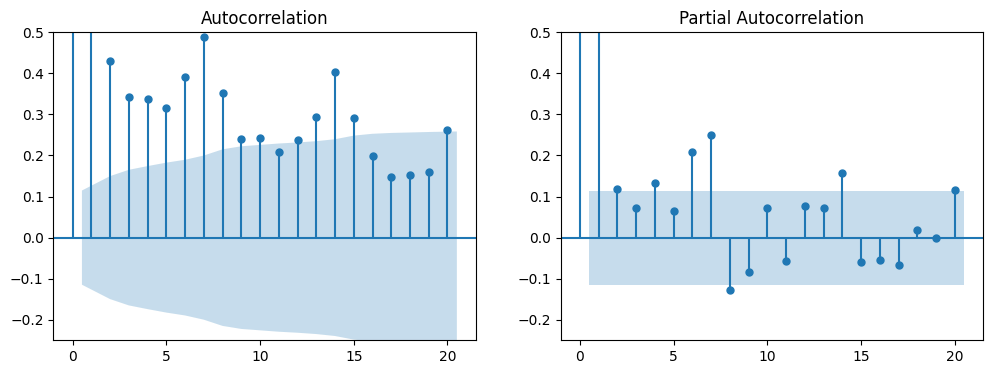

In [6]:
# Log‐transform realized variance and volatility
rvar = np.log(rv_train['RV_ANNUALIZED']).dropna()
rvol = np.log(rv_train['RV_ANNUALIZED']).dropna()

# ADF test on log‐realized variance
adf_p = adfuller(rvar.dropna())[1]
print(f"ADF p-value: {adf_p:.5f} → Data is {'stationary' if adf_p < 0.05 else 'not stationary'}")

# ACF and PACF plots for log‐realized variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(rvar, lags=20, ax=axes[0])
plot_pacf(rvar, lags=20, ax=axes[1])

axes[0].set_ylim(-0.25, 0.50)
axes[1].set_ylim(-0.25, 0.50)
plt.show()

We now estimate our volatility models on log-realized variance and perform diagnostic checks. We start with GARCH(1,1) and FIGARCH(1,d,1), which have a **constant mean** and focus on the dynamic structure of the **conditional variance**. 

---

# 1. GARCH(1,1)

We model the realized‐variance series $r_t$ as  
$$
r_t = \mu + \varepsilon_t,
\qquad
\varepsilon_t = \sigma_t\,z_t,\quad z_t\sim D(0,1)
$$  
with conditional variance  
$$
\sigma_t^2 = \omega \;+\;\alpha\,\varepsilon_{t-1}^2 \;+\;\beta\,\sigma_{t-1}^2.
$$
   
   - **$\omega$ (omega)** acts as the “floor” or baseline for variance.  
   - **$\alpha$ (ARCH effect)** governs the immediate impact of yesterday’s shock on today’s variance. 
   - **$\beta$ (GARCH effect)** captures the persistence of yesterday’s variance. 

When $\alpha + \beta < 1$, the variance is **mean-reverting** towards the unconditional long-run variance:

$$
\mathbb{E}[h_t] = \frac{\omega}{1 - \alpha_1 - \beta_1}.
$$

---

# 2. FIGARCH(1,d,1)

We introduce a fractional differencing parameter $d\in(0,1)$ to capture long‑memory in volatility:

$$
\bigl(1 - \beta L\bigr)\,(1 - L)^d\,\sigma_t^2
= \omega + \alpha\,\varepsilon_{t-1}^2,
$$
 
- $(1 - L)^d = \sum_{k=0}^\infty \binom{d}{k}(-L)^k$ gives hyperbolic decay in the ACF. 
- $\omega>0$, $\alpha\ge0$, $\beta\ge0$ as usual. 

This is relevant for $r_t$ because the ACF for realized variance decays slowly out to 20 lags (with bumps at lags 8–10), indicating persistence beyond a few days. This model captures directly that “long‑memory” behavior without requiring many AR terms.

---


=== GARCH(1,1) on log‐RV ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          RV_ANNUALIZED   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -374.999
Distribution:                  Normal   AIC:                           757.997
Method:            Maximum Likelihood   BIC:                           772.704
                                        No. Observations:                  292
Date:                Sun, Nov 16 2025   Df Residuals:                      291
Time:                        12:54:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -2.1321  8.684e-02    -24.

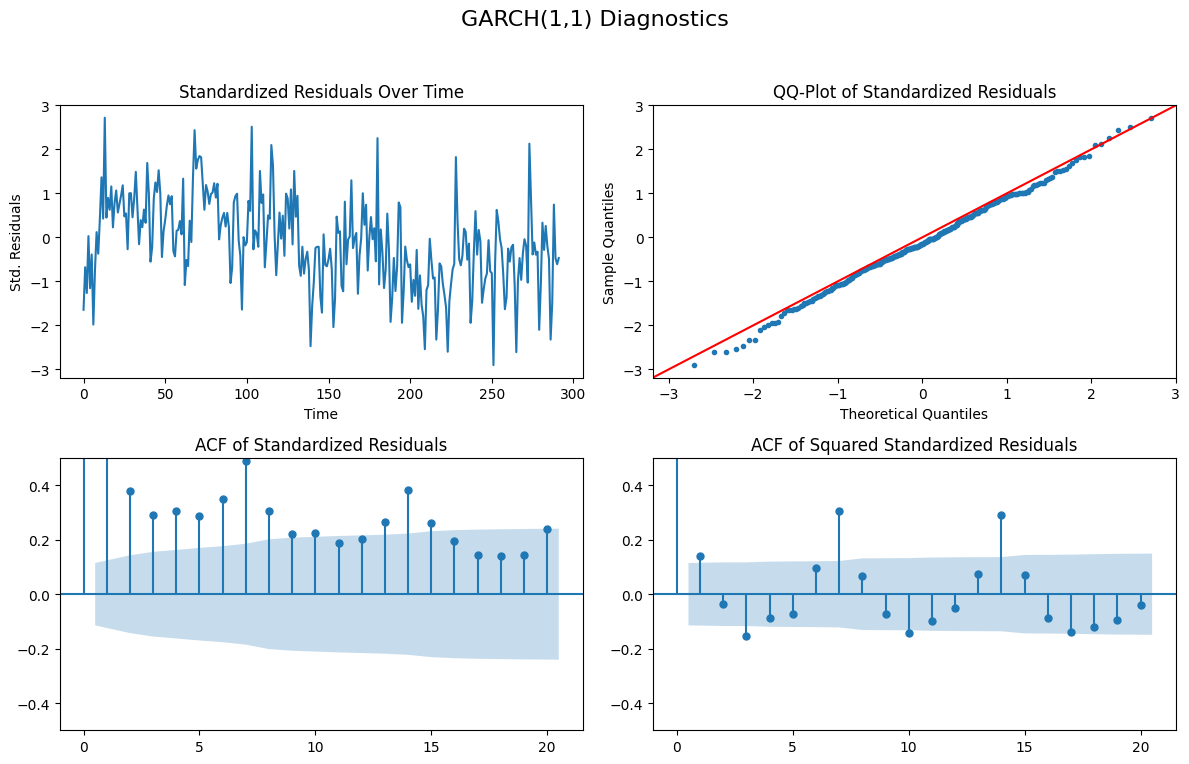


=== FIGARCH(1,d,1) on log‐RV ===
                    Constant Mean - FIGARCH Model Results                     
Dep. Variable:          RV_ANNUALIZED   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:               -371.810
Distribution:                  Normal   AIC:                           753.619
Method:            Maximum Likelihood   BIC:                           772.003
                                        No. Observations:                  292
Date:                Sun, Nov 16 2025   Df Residuals:                      291
Time:                        12:54:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -2.1515  8.090e-02    

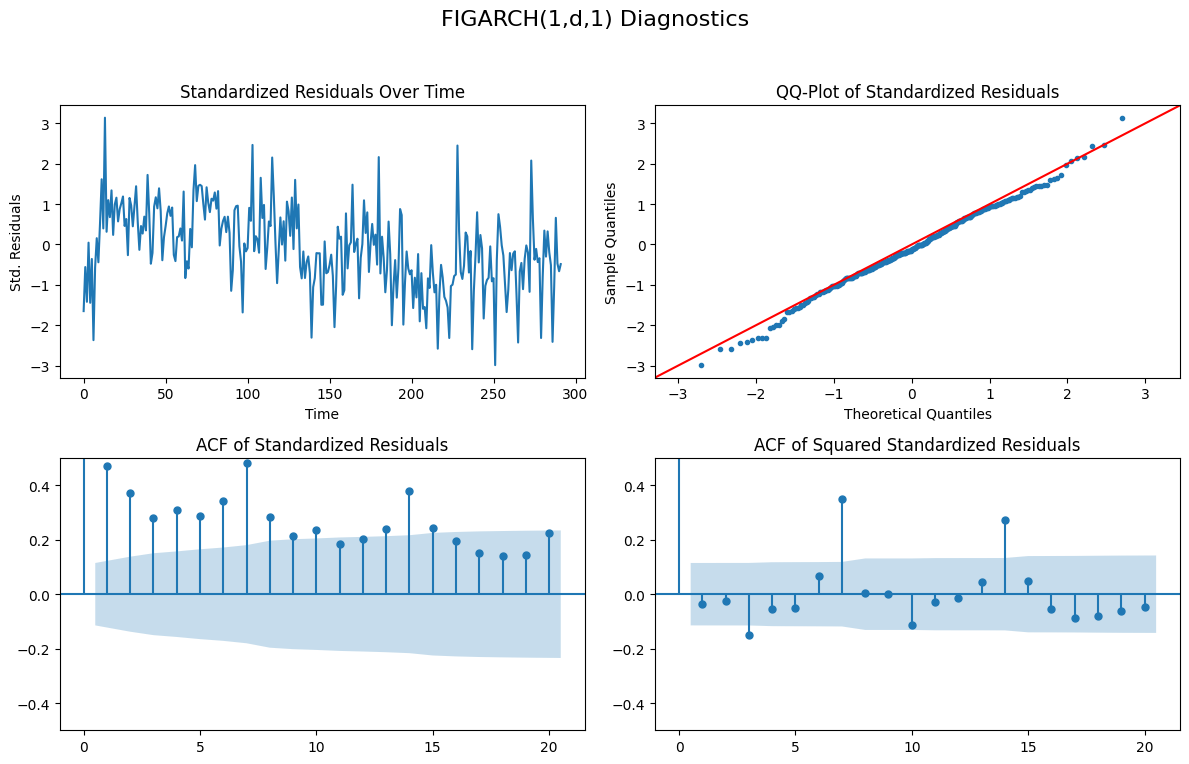

In [7]:
# Instantiate GARCH(1,1) and FIGARCH(1,d,1) on rvar
models = [RvModels("GARCH(1,1)", rvar), RvModels("FIGARCH(1,d,1)", rvar)]
models[0].fit(p=1, o=0, q=1, vol='Garch', dist='normal')
models[1].fit(p=1, o=0, q=1, vol='FIGARCH', dist='normal')

# Get summaries and diagnostics
for m in models:
    print(f"\n=== {m.name} on log‐RV ===")
    m.summary()
    m.plot_diagnostics()

We now turn to **mean-equation models**, namely AR(p)–GARCH(1,1) and ARMA(p,q)–GARCH(1,1). 

---

# 1. AR(p)–GARCH(1,1)

This model combines an autoregressive (AR) mean equation with a GARCH(1,1) variance equation:

$$
\begin{aligned}
r_t &= \mu + \phi_1\,r_{t-1} + \cdots + \phi_p\,r_{t-p} + \varepsilon_t,\\
\varepsilon_t &= \sigma_t\,z_t,\quad z_t \sim \mathrm{Skew}\text{-}t(\nu,\lambda),\\
\sigma_t^2 &= \omega + \alpha\,\varepsilon_{t-1}^2 + \beta\,\sigma_{t-1}^2.
\end{aligned}
$$

The **mean equation** captures persistence via past values of $r_t$ while the **variance equation** models volatility clustering.  

---

# 2. ARMA(p,q)–GARCH(1,1)

We augment the mean equation with a moving‑average component. 

$$
\begin{aligned}
r_t &= \mu
      + \sum_{i=1}^{p} \phi_i\,r_{t-i}
      + \sum_{j=1}^{q} \theta_j\,\varepsilon_{t-j}
      + \varepsilon_t,\\
\varepsilon_t &= \sigma_t\,z_t,\quad z_t \sim \mathrm{Skew}\text{-}t(\nu,\lambda),\\
\sigma_t^2 &= \omega + \alpha\,\varepsilon_{t-1}^2 + \beta\,\sigma_{t-1}^2.
\end{aligned}
$$

The **mean equation** includes both autoregressive terms $\phi_i$ and moving‑average terms $\theta_j$, allowing the model to absorb short‑term shocks directly. ARMA–GARCH offers greater flexibility for transient effects but at the cost of more parameters and potential overfitting.

---



=== AR(3)–GARCH(1,1) ===
                           AR - GARCH Model Results                           
Dep. Variable:          RV_ANNUALIZED   R-squared:                       0.361
Mean Model:                        AR   Adj. R-squared:                  0.355
Vol Model:                      GARCH   Log-Likelihood:               -315.661
Distribution:                  Normal   AIC:                           645.323
Method:            Maximum Likelihood   BIC:                           670.988
                                        No. Observations:                  289
Date:                Sun, Nov 16 2025   Df Residuals:                      285
Time:                        12:54:21   Df Model:                            4
                                  Mean Model                                  
                    coef    std err          t      P>|t|     95.0% Conf. Int.
------------------------------------------------------------------------------
Const            -0.7062  

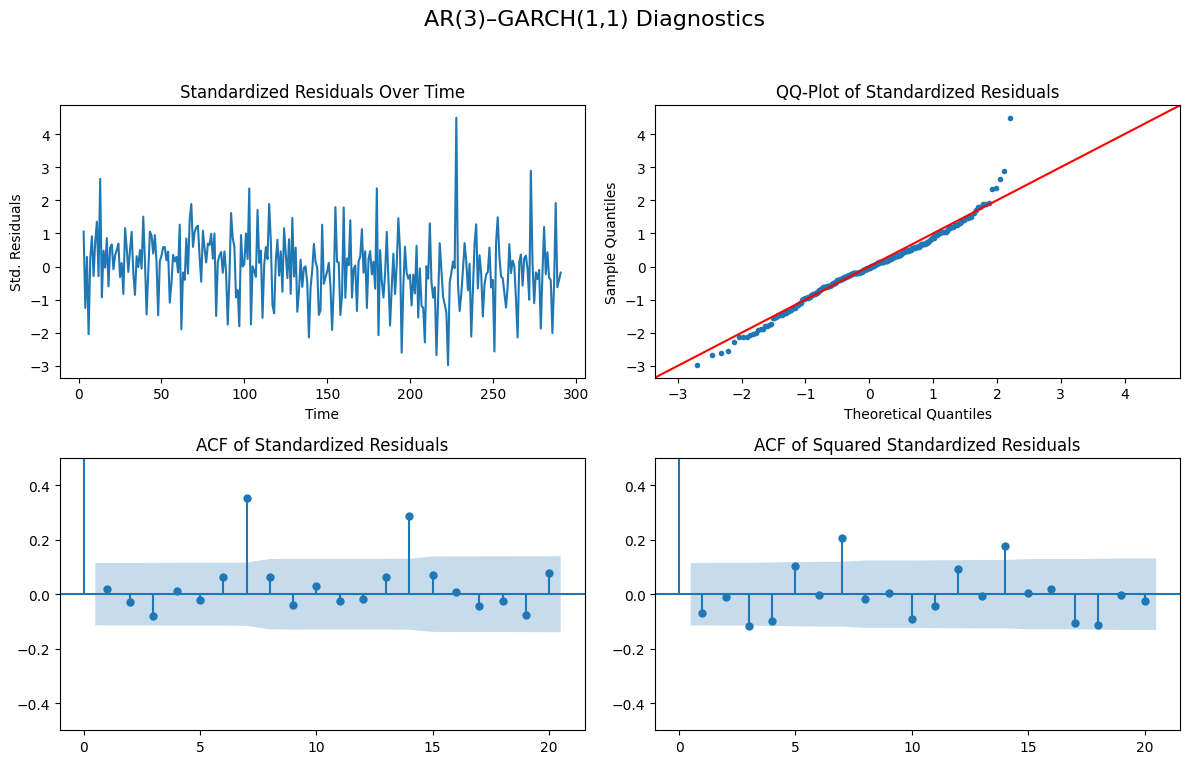

/Users/pauldefressenel/Desktop/base/garch/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pauldefressenel/Desktop/base/garch/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



=== ARMA(3,3)–GARCH(1,1) ===
                             Zero Mean - GARCH Model Results                             
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.003
Vol Model:                                 GARCH   Log-Likelihood:               -297.820
Distribution:      Standardized Skew Student's t   AIC:                           605.640
Method:                       Maximum Likelihood   BIC:                           624.024
                                                   No. Observations:                  292
Date:                           Sun, Nov 16 2025   Df Residuals:                      292
Time:                                   12:54:21   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----

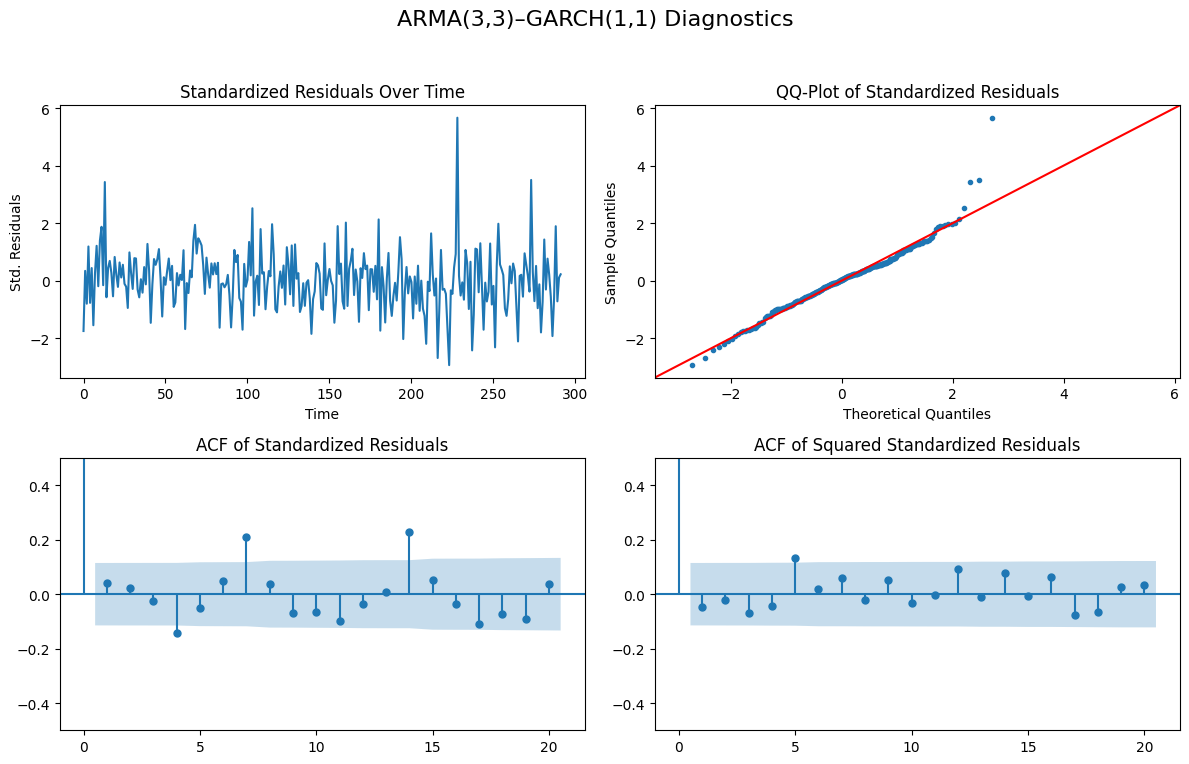

In [8]:
# Instantiate AR(3)–GARCH(1,1) on rvar
ar_garch = RvModels("AR(3)–GARCH(1,1)", rvar)
ar_garch.fit(mean='AR', lags=3, vol='Garch', p=1, o=0, q=1, dist='normal')

# Get summaries and diagnostics
print("\n=== AR(3)–GARCH(1,1) ===")
ar_garch.summary()
ar_garch.plot_diagnostics()

# Obtain ARMA(3,3)–GARCH(1,1) via two‐step filter

# a) Fit an ARMA(3,3) on rvar
arma_model = ARIMA(rvar, order=(3,0,3)).fit(
    method_kwargs={'maxiter': 200,'warn_convergence': True})

# b) Extract residuals and feed into a zero‐mean GARCH
arma_garch = RvModels("ARMA(3,3)–GARCH(1,1)", arma_model.resid)
arma_garch.fit(mean='Zero', vol='Garch', p=1, o=0, q=1, dist='skewt')

# c) Get summaries and diagnostics
print("\n=== ARMA(3,3)–GARCH(1,1) ===")
arma_garch.summary()
arma_garch.plot_diagnostics()


# Heterogeneous Autoregressive (HAR) Models for Realized Volatility

The **HAR** model, introduced by Francesco Corsi (2009), is designed to capture the **long‑memory** and **heterogeneous trading‐horizon** features of high‑frequency realized volatility.  Instead of an ARMA model on volatility, it decomposes past volatility into components associated with different horizons:

$$
\mathrm{RV}_t
= \beta_0
\;+\;\beta_1\,\mathrm{RV}_{t-1}
\;+\;\beta_2\,\frac{1}{5}\sum_{i=1}^5\mathrm{RV}_{t-i}
\;+\;\beta_3\,\frac{1}{22}\sum_{i=1}^{22}\mathrm{RV}_{t-i}
\;+\;\varepsilon_t,
$$

where  
- $ \mathrm{RV}_t $ is the **daily realized variance**   ;   $ \mathrm{RV}_{t-1} $ is the **one‑day lag**   ;   $ \displaystyle \frac{1}{5}\sum_{i=1}^5\mathrm{RV}_{t-i} $ is the **weekly** (5‑day) average   ;   $ \displaystyle \frac{1}{22}\sum_{i=1}^{22}\mathrm{RV}_{t-i} $ is the **monthly** (≈22‑day) average  
- and $ \varepsilon_t $ is an approximately white‑noise error term  

---

### Why HAR Works Well

1. **Approximate long memory**  
   Financial volatility often displays slowly‑decaying autocorrelations.  The HAR structure—with separate daily, weekly and monthly lags—**approximates** a long‑memory process without requiring fractional integration.

2. **Economic interpretation**  
   Different classes of market participants (high‑frequency traders, mutual funds, pension funds) operate on different horizons.  HAR’s multiple lags map naturally to these horizon effects.

3. **Forecasting performance**  
   Empirically, HAR models often **outperform** ARMA or pure GARCH models for one‑day and multi‑day realized volatility forecasts (Corsi, 2009; Andersen et al., 2003).

### Why extend HAR to HAR‑GARCH?

The plain HAR model  
$$
RV_t \;=\; \beta_0 + \beta_1RV_{t-1} + \beta_2\overline{RV}_{t-1:t-5} + \beta_3\overline{RV}_{t-1:t-22} + \varepsilon_t
$$  
captures the **mean** dynamics of daily realized variance, but it assumes the residuals $\varepsilon_t$ are homoskedastic. A HAR‑GARCH augments this by modeling the **conditional variance** of $\varepsilon_t$ itself:

$$
h_t \;=\; \omega + \alpha\,\varepsilon_{t-1}^2 + \beta\,h_{t-1}
\,,\quad
\varepsilon_t \sim t_\nu(0,\,h_t).
$$

We might bother with HAR‑GARCH for:

1. **Multi‑step forecasting of variance**  
   If we want a full **density forecast** of  
   $$
   RV_{t+h}
   $$  
   (not just a point forecast of its mean), a GARCH error term with Student‑$t$ tails lets us produce **time‑varying forecast variances** for $\varepsilon_{t+h}$ and hence a full predictive distribution.

2. **Heavy‑tail management**  
   Even if the squared‐resid ACF is small, we still have some extreme outliers in the QQ. A HAR‑GARCH(t) should build those into its conditional variance equation and give us volatility forecasts that swell up around those event dates.

4. **Risk metrics**  
   For computing **VaR** or **Expected Shortfall (ES)** on realized volatility itself, GARCH provides the evolving **uncertainty** around our daily‐variance forecasts, rather than assuming constant error variance.
   
---

## Key References

1. **Corsi, Francesco** (2009). “A Simple Approximate Long‑Memory Model of Realized Volatility.” *Journal of Financial Econometrics*, 7(2), 174–196.  
2. **Andersen, Torben G.; Bollerslev, Tim; Diebold, Francis X.; Labys, Paul** (2003). “Modeling and Forecasting Realized Volatility.” *Econometrica*, 71(2), 579–625.  


=== HAR(1,5)–GARCH(1,1) ===
                                HAR - GARCH Model Results                                
Dep. Variable:                     RV_ANNUALIZED   R-squared:                       0.405
Mean Model:                                  HAR   Adj. R-squared:                  0.398
Vol Model:                                 GARCH   Log-Likelihood:               -267.047
Distribution:      Standardized Skew Student's t   AIC:                           552.094
Method:                       Maximum Likelihood   BIC:                           584.480
                                                   No. Observations:                  270
Date:                           Sun, Nov 16 2025   Df Residuals:                      266
Time:                                   12:54:30   Df Model:                            4
                                    Mean Model                                   
                       coef    std err          t      P>|t|     95.0% Conf. In

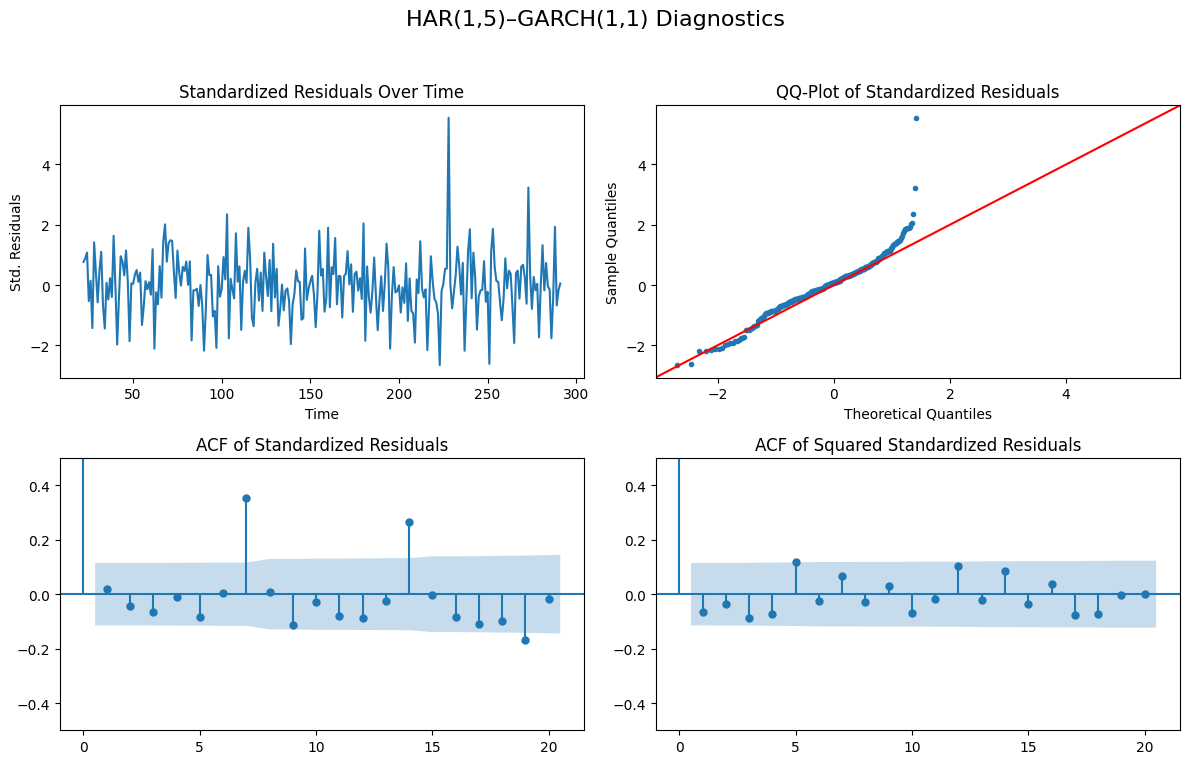

In [9]:
# Instantiate the HAR(1,5)–GARCH(1,1) on rvar
har = RvModels("HAR(1,5)–GARCH(1,1)", rvar)
har.fit(mean='HAR', lags=(1, 5, 22), vol='Garch', p=1, o=0, q=1, dist='skewt')

# Get summaries and diagnostics
print("\n=== HAR(1,5)–GARCH(1,1) ===")
har.summary()
har.plot_diagnostics()

## Out‑of‑Sample Validation of Rolling Forecasts

Rather than fitting once and forecasting all test points at once, we use a **rolling‐window, recursive forecast** approach:

1. **Split** our data into a training set (first 80 %) and a test set (last 20 %).  
2. **For each day** \(t\) in the test period:
   - **Re‑fit** the model on all available data up to time \(t-1\) (i.e.\ the original training data plus any prior test observations).  
   - **Generate a one‑step‑ahead forecast** for day \(t\) using that freshly estimated model.  
3. **Collect** the day‑by‑day forecasts into a single series aligned with the test dates.  
4. **Compute loss metrics** (MSE, MAE on log‑RV; QLIKE on level‑RV) by comparing these rolling forecasts to the realized values in the test set.

This ensures that at each forecast origin the model only “knows” information up to that point—mimicking true real‑time forecasting and preventing look‑ahead bias.

---

### 1) Mean Squared Error (MSE)

$$
\mathrm{MSE} \;=\; \frac{1}{T}\sum_{t=1}^{T}\bigl(\hat y_{t} - y_{t}\bigr)^{2},
$$

where $\hat y_{t}$ is our forecast and $y_{t}$ the observed log realized variance.  

---

### 2) Mean Absolute Error (MAE)

$$
\mathrm{MAE} \;=\; \frac{1}{T}\sum_{t=1}^{T}\bigl|\hat y_{t} - y_{t}\bigr|.
$$

This metric treats all errors linearly and is more robust to extreme outliers than MSE.  

---

### 3) Quasi‑Likelihood (QLIKE)

For variance forecasts, QLIKE is a **strictly proper** scoring rule:

$$
\mathrm{QLIKE} 
\;=\; \frac{1}{T}\sum_{t=1}^{T}\Bigl(\frac{y_{t}}{\hat y_{t}}
\;-\;\ln\!\bigl(\tfrac{y_{t}}{\hat y_{t}}\bigr)
\;-\;1\Bigr).
$$

QLIKE penalizes under‑forecasting more heavily and aligns with the Gaussian log‑likelihood.  

---

Out‑of‑Sample Metrics (level scale):
            MSE       MAE     QLIKE
MODEL                              
AR3    3.68E-02  9.38E-02  3.72E-01
NAIVE  6.14E-02  1.26E-01  5.01E-01


/var/folders/hg/whn0f0wx0sgf_r422wxs9ds80000gn/T/ipykernel_34351/769319352.py:109: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.2E}")


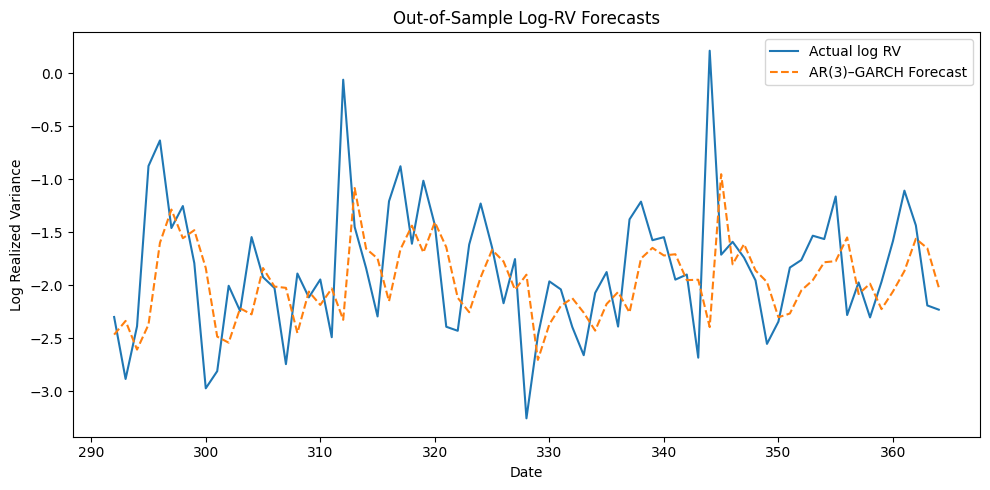

In [10]:
# Prepare level‐RV train and test
rv_train_var = rv_train['RV_ANNUALIZED']
rv_test_var  = rv_test ['RV_ANNUALIZED']
length = len(rv_test_var)

# Rolling one‐step forecasts for AR(3)–GARCH(1,1)
preds_ar3 = []
for i in range(length):
    hist_var = pd.concat([rv_train_var, rv_test_var.iloc[:i]])
    y_hist = np.log(hist_var) 

    model_ar3 = RvModels("AR(3)–GARCH(1,1)", y_hist)
    model_ar3.fit(mean='AR', lags=3, vol='Garch',
                  p=1, o=0, q=1, dist='skewt')

    fc = model_ar3.res.forecast(horizon=1, reindex=False)
    pred_log = fc.mean.iloc[-1, 0]
    preds_ar3.append(pred_log)

# Assemble results DataFrame 
results = pd.DataFrame({
    'ACTUAL_LOG_RV': np.log(rv_test_var.values),
    'PRED_LOG_RV_AR3': np.array(preds_ar3),
}, index=rv_test_var.index)
results['PRED_LOG_RV_NAIVE'] = results['ACTUAL_LOG_RV'].shift(1)

# Compute level‐scale metrics using our class method
level_metrics_df = models[0].level_metrics(results)

print("Out‑of‑Sample Metrics (level scale):")
print(level_metrics_df)

# Plot actual vs. forecasts on log‐scale
plt.figure(figsize=(10, 5))
plt.plot(results['ACTUAL_LOG_RV'], label='Actual log RV', linewidth=1.5)
plt.plot(results['PRED_LOG_RV_AR3'], '--', label='AR(3)–GARCH Forecast', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Log Realized Variance')
plt.title('Out‑of‑Sample Log‑RV Forecasts')
plt.legend()
plt.tight_layout()
plt.show()

## Appendix: Augmented Dickey–Fuller (ADF) Test

The Augmented Dickey–Fuller test checks for a unit root in a univariate time series $y_t$, i.e. whether the series is non‑stationary. It does so by estimating a regression that augments the basic Dickey–Fuller equation with lagged differences to absorb serial correlation.

---

### 1. Test Regression Equations

- **No intercept, no trend**  
$$
\Delta y_t = \gamma\,y_{t-1} + \sum_{i=1}^{p}\delta_i\,\Delta y_{t-i} + \varepsilon_t
$$

- **With intercept**  
$$
\Delta y_t = \alpha + \gamma\,y_{t-1} + \sum_{i=1}^{p}\delta_i\,\Delta y_{t-i} + \varepsilon_t
$$

- **With intercept and linear trend**  
$$
\Delta y_t = \alpha + \beta\,t + \gamma\,y_{t-1} + \sum_{i=1}^{p}\delta_i\,\Delta y_{t-i} + \varepsilon_t
$$

Here  
- $\Delta y_t = y_t - y_{t-1}$  
- $p$ is the number of lagged differences (chosen by AIC/BIC or sequential tests)  
- $\varepsilon_t$ is white noise  

---

### 2. Hypotheses

$$
H_0: \gamma = 0 \quad(\text{unit root, non‑stationary})  
\quad\text{vs.}\quad  
H_1: \gamma < 0 \quad(\text{stationary})
$$

---

### 3. Test Statistic

Fit the chosen regression and compute
$$
\hat{\gamma}, \quad \mathrm{SE}(\hat{\gamma})
\quad\Longrightarrow\quad
\tau_{\mathrm{ADF}} = \frac{\hat{\gamma}}{\mathrm{SE}(\hat{\gamma})}.
$$
Compare $\tau_{\mathrm{ADF}}$ to critical values from the ADF distribution. If
$$
\tau_{\mathrm{ADF}} < \text{(critical value at your chosen significance)},
$$
you reject $H_0$ and conclude the series is stationary.

---

### 4. p‑Value

The p‑value is obtained by comparing $\tau_{\mathrm{ADF}}$ against its simulated distribution under the null of a unit root.

---